In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import haversine as hs
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, TransformerConv,PDNConv,SuperGATConv,GATv2Conv
seed = 42
random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = xr.open_dataset("data/delhi_cpcb_2022.nc")

In [3]:
df_ = data.to_dataframe().reset_index()


df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=['PM2.5'])
le = LabelEncoder()
df['station_le'] = le.fit_transform(df['station'])



In [4]:
df

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude,station_le
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.00,3.78,43.38,26.15,3.42,...,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010,0
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.00,11.88,30.62,26.02,15.82,...,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809,1
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.00,7.47,67.17,41.80,50.77,...,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665,2
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.30,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936,3
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.00,4.80,20.65,25.43,41.45,...,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074,4
45332,"Burari Crossing, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.81,158.79,NaN,NaN,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.725650,77.201157,5
54115,"CRRI Mathura Road, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,109.78,305.51,99.26,18.77,118.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.551201,77.273574,6
62898,"Chandni Chowk, Delhi - IITM",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,40.15,247.45,28.02,128.16,89.75,81.71,...,1.21,78.50,NaN,999.28,17.39,0.0,0.0,28.656756,77.227234,7
71681,"DTU, Delhi - CPCB",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.83,145.75,7.80,24.82,19.45,23.85,...,0.45,130.91,NaN,NaN,NaN,NaN,0.0,28.750050,77.111261,8
80464,"Dr. Karni Singh Shooting Range, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,78.50,218.75,73.85,95.58,111.05,14.77,...,0.88,294.10,5.20,988.48,11.15,0.0,0.0,28.498571,77.264840,9


In [5]:
station = {}
lat = []
long = []
for i in df.station_le.unique():
    lat_i = df[df['station_le'] == i]['latitude'].item()
    long_i = df[df['station_le'] == i]['longitude'].item()
    pm_i = df[df['station_le'] == i]['PM2.5'].item()
    s_name = df[df['station_le'] == i]['station'].item()
    # co = df_impute[df_impute['station'] == i]['CO']
    
    
    station[i] = [lat_i, long_i, pm_i,s_name]
    long.append(long_i)
    lat.append(lat_i)

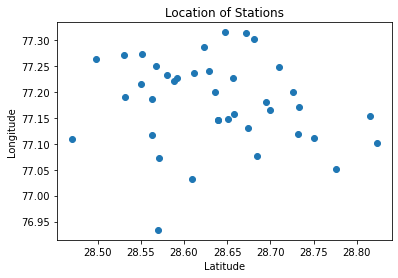

In [6]:
plt.scatter(y = long, x = lat)
plt.title('Location of Stations')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

In [7]:
station

{0: [28.815329, 77.15301, 70.0, 'Alipur, Delhi - DPCC'],
 1: [28.647622, 77.315809, 52.5, 'Anand Vihar, Delhi - DPCC'],
 2: [28.695381, 77.181665, 79.0, 'Ashok Vihar, Delhi - DPCC'],
 3: [28.4706914, 77.1099364, 73.94, 'Aya Nagar, Delhi - IMD'],
 4: [28.7762, 77.051074, 135.0, 'Bawana, Delhi - DPCC'],
 5: [28.7256504, 77.2011573, 52.81, 'Burari Crossing, Delhi - IMD'],
 6: [28.5512005, 77.2735737, 109.78, 'CRRI Mathura Road, Delhi - IMD'],
 7: [28.656756, 77.227234, 40.15, 'Chandni Chowk, Delhi - IITM'],
 8: [28.7500499, 77.1112615, 79.83, 'DTU, Delhi - CPCB'],
 9: [28.498571,
  77.26484,
  78.5,
  'Dr. Karni Singh Shooting Range, Delhi - DPCC'],
 10: [28.5710274, 77.0719006, 80.0, 'Dwarka-Sector 8, Delhi - DPCC '],
 11: [28.5627763, 77.1180053, 61.8, 'IGI Airport (T3), Delhi - IMD'],
 12: [28.6811736, 77.3025234, 75.65, 'IHBAS, Dilshad Garden, Delhi - CPCB'],
 13: [28.628624, 77.24106, 82.0, 'ITO, Delhi - CPCB'],
 14: [28.73282, 77.170633, 90.75, 'Jahangirpuri, Delhi - DPCC'],
 15: [2

In [8]:
def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    return hs.haversine((lat1, lon1), (lat2, lon2))

distances = [] #Store distance between each pair of nodes
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)


In [9]:
for i in range(len(distances)):
    distances[i].sort()

In [10]:
import networkx as nx

no_of_neighbours = 8

G = nx.Graph()

for i in station.keys():
    G.add_node(i, latitude = station[i][0], longitude = station[i][1], pm = station[i][2], station = station[i][3])
    
    for j in range(no_of_neighbours): #Add edge connecting nodes closest to current node
        s = distances[i][j][1]
        G.add_node(s, latitude = station[s][0], longitude = station[s][1], pm = station[s][2])
        G.add_edge(i, s)


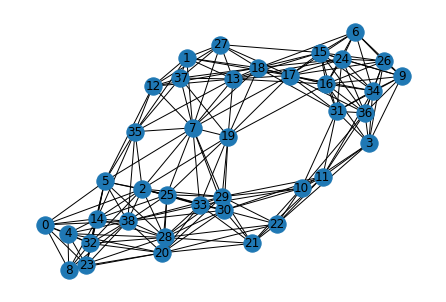

In [11]:
layout1 = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
nx.draw(G, pos=layout1, with_labels=True)
plt.show()

In [12]:
node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)

In [13]:
y.t().squeeze()

tensor([ 70.0000, 111.7500,  79.8300,  90.7500, 124.6700, 135.0000,  52.8100,
         94.0000,  79.0000,  52.5000,  58.5000,  75.0000,  75.6500,  82.0000,
        110.7500,  40.1500,  55.0000,  40.4900,  22.4100, 113.0000,  51.6200,
         66.6700,  73.9400,  61.8000,  63.0000,  80.0000,  90.0000,  77.5000,
         78.5000, 209.8800,  83.0000, 115.0000, 109.7800,  93.2500,  72.7500,
        174.4500, 103.0000,  59.7200,  84.7500])

In [14]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GATv2Conv(input_dim, 16)
        self.conv2 = GATv2Conv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [15]:
G.nodes[0]

{'latitude': 28.815329,
 'longitude': 77.15301,
 'pm': 70.0,
 'station': 'Alipur, Delhi - DPCC'}

In [16]:
dataframe = []

In [19]:

#GNN
def run_model(G):
    node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    for super in list(G.nodes()):
        print(super)
        # sorted_nodes = sorted(G.nodes(), key=lambda node: G.nodes[node]['latitude'])

        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            # lat = G.nodes[node]['latitude']
            # if lat in lat_list[:30]:
            #     train_mask[i] = True
            # else:
            #     test_mask[i] = True
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True

        data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)
        model1 = RegressionModel(input_dim=2).to(device)
        optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        
        #Train GNN
        for epoch in range(2500):
            optimizer.zero_grad()
            out = model1(data1.x.to(device), data1.edge_index.to(device))
            loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
            loss.backward()
            optimizer.step()
        
        #GNN Output
        model1.eval()
        with torch.no_grad():
            out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
            train_rmse_g = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
            test_rmse_g = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))

        g_pred = out[data1.test_mask].squeeze().tolist()
        actual = data1.y[data1.test_mask].squeeze().tolist()
        # actual = G.nodes[i]["pm"]
        # print(test_mask)
        #Mean Value
        train_mean = torch.mean(data1.y[data1.train_mask])
        mean_pred = int(data1.test_mask.sum())*[float(train_mean)]
        mean_rmse_test = torch.sqrt(torch.mean((train_mean - data1.y[data1.test_mask].squeeze())**2))
        
        #Prepare Data for LR and RF
        X_train = data1.x[data1.train_mask].numpy()
        y_train = data1.y[data1.train_mask].numpy().reshape(-1)
        X_test = data1.x[data1.test_mask].numpy()
        y_test = data1.y[data1.test_mask].numpy().reshape(-1)
        # print(y_train.shape)
        #Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        y_test_pred_lr = lr_model.predict(X_test)
        test_rmse_lr = torch.sqrt(torch.mean((torch.tensor(y_test_pred_lr) - data1.y[data1.test_mask])**2))

        #Random Forest
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        y_test_pred_rf = rf_model.predict(X_test)
        test_rmse_rf = torch.sqrt(torch.mean((torch.tensor(y_test_pred_rf) - data1.y[data1.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        y_test_pred_knn = knn_model.predict(X_test)
        test_rmse_knn = torch.sqrt(torch.mean((torch.tensor(y_test_pred_knn) - data1.y[data1.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(weights = 'distance')
        idw_model.fit(X_train, y_train)
        y_test_pred_idw = idw_model.predict(X_test)
        test_rmse_idw = torch.sqrt(torch.mean((torch.tensor(y_test_pred_idw) - data1.y[data1.test_mask])**2))
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "knn rmse": float(test_rmse_knn),
                            "mean rmse": float(mean_rmse_test),
                            "idw rmse": float(test_rmse_idw),
                            "lr rmse": float(test_rmse_lr),
                            "rf rmse": float(test_rmse_rf),
                            "gnn rmse": float(test_rmse_g),
                            "actual": actual,
                            "knn pred": y_test_pred_knn[0],
                            "mean pred": mean_pred[0],
                            "idw pred": y_test_pred_idw[0],
                            "lr pred": y_test_pred_lr[0],
                            "rf pred": y_test_pred_rf[0],
                            "gnn pred": g_pred,    
                           })

        # return float(test_rmse_knn), float(mean_rmse_test), float(test_rmse_lr), float(test_rmse_rf), float(test_rmse_g), g_pred, y_test_pred_rf, actual, y_test_pred_lr, mean_pred, y_test_pred_knn
    print("hello",i)

In [28]:
#Set Timestamps
p = pd.date_range(start='2022-02-10 01:30:00', end='2022-08-15 01:30:00', freq = '12H').to_frame(name='dates')

run_model(G)

In [21]:
df_results = pd.DataFrame(dataframe)

In [22]:
df_results

,node,lat,lon,pm,knn rmse,mean rmse,idw rmse,lr rmse,rf rmse,gnn rmse,actual,knn pred,mean pred,idw pred,lr pred,rf pred,gnn pred
0,"Alipur, Delhi - DPCC",28.815329,77.153010,70.00,25.976250,15.312370,24.952064,20.716797,7.597064,15.414330,70.000000,95.976250,85.312370,94.952064,90.716797,77.597064,85.414330
1,"Narela, Delhi - DPCC",28.822836,77.101981,111.75,16.492500,27.536316,14.181703,21.277344,17.100069,27.574654,111.750000,95.257500,84.213684,97.568297,90.472656,94.649931,84.175346
2,"DTU, Delhi - CPCB",28.750050,77.111261,79.83,26.941246,5.223686,35.888635,14.390701,34.937344,5.254211,79.830002,106.771248,85.053688,115.718637,94.220703,114.767346,85.084213
3,"Jahangirpuri, Delhi - DPCC",28.732820,77.170633,90.75,13.160004,5.983681,7.473230,5.227539,10.301690,5.983719,90.750000,77.589996,84.766319,83.276770,85.522461,80.448310,84.766281
4,"Rohini, Delhi - DPCC",28.732528,77.119920,124.67,29.746246,40.796310,31.865578,34.969803,36.427085,38.622124,124.669998,94.923752,83.873688,92.804420,89.700195,88.242913,86.047874
5,"Bawana, Delhi - DPCC",28.776200,77.051074,135.00,35.125000,51.398155,34.212962,40.351562,2.442291,51.325928,135.000000,99.875000,83.601845,100.787038,94.648438,132.557709,83.674072
6,"Burari Crossing, Delhi - IMD",28.725650,77.201157,52.81,24.562496,32.954739,23.714677,31.168514,29.466418,34.036892,52.810001,77.372498,85.764740,76.524678,83.978516,82.276420,86.846893
7,"Wazirpur, Delhi - DPCC",28.699793,77.165453,94.00,14.342499,9.319206,19.845805,7.737305,23.867133,11.954475,94.000000,79.657501,84.680794,74.154195,86.262695,70.132867,82.045525
8,"Ashok Vihar, Delhi - DPCC",28.695381,77.181665,79.00,12.573746,6.075531,1.218985,5.828125,5.111947,8.402519,79.000000,66.426254,85.075531,77.781015,84.828125,84.111947,87.402519
9,"Anand Vihar, Delhi - DPCC",28.647622,77.315809,52.50,21.287498,33.272896,21.301015,17.587891,11.329105,33.280228,52.500000,73.787498,85.772896,73.801015,70.087891,63.829105,85.780228


In [27]:
print('KNN RMSE: ', np.mean(df_results['knn rmse']))
print('Mean RMSE: ', np.mean(df_results['mean rmse']))
print('IDW RMSE: ', np.mean(df_results['idw rmse']))
print('RF RMSE: ', np.mean(df_results['rf rmse']))
print('LR RMSE: ', np.mean(df_results['lr rmse']))
print('GNN RMSE: ', np.mean(df_results['gnn rmse']))

KNN RMSE:  26.376026544815456
Mean RMSE:  25.600188230856872
IDW RMSE:  28.21941025250181
RF RMSE:  27.344577739288
LR RMSE:  26.08002178485577
GNN RMSE:  26.455977806678185
